In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os
from PIL import Image

2024-10-20 22:22:15.861331: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-20 22:22:15.930487: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-20 22:22:16.023861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 22:22:16.130996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 22:22:16.149976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 22:22:16.297886: I tensorflow/core/platform/cpu_feature_gu

In [2]:
TRAIN_DIR = '/home/kikosolovic/Desktop/DogCatModel/dogs-vs-cats-redux-kernels-edition/train'
TEST_DIR = '/home/kikosolovic/Desktop/DogCatModel/dogs-vs-cats-redux-kernels-edition/test'
IMG_SIZE = 50
LR = 1e-3



In [3]:
def load_images(directory, label, cat):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith((".jpg", ".png")):
            # Corrected filename splitting and comparison
            is_cat_image = filename.split(".")[0].startswith("cat")
            if is_cat_image == cat:
                img = Image.open(os.path.join(directory, filename))
                img = img.resize((50, 50))  # Resize images to a consistent size
                img_array = np.array(img) / 255.0  # Normalize pixel values
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)


In [4]:
# Load dog images
dog_images, dog_labels = load_images(TRAIN_DIR, 1, False)

# Load cat images
cat_images, cat_labels = load_images(TRAIN_DIR, 0, True)


In [5]:
X = np.concatenate((dog_images, cat_images), axis=0)
y = np.concatenate((dog_labels, cat_labels), axis=0)


In [6]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]


In [7]:
# Split into train and test sets
split = int(0.8 * X.shape[0])
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [8]:
print(X_train.shape[0])

20000


In [9]:
def PrepareSignleImg(path):
    # "/home/kikosolovic/Downloads/image2.jpg"
    img = Image.open(path)
    img = img.resize((50, 50))  # Resize images to a consistent size
    img_array = np.array(img) / 255.0  # Normalize pixel values
    return np.expand_dims(img_array, axis=0)


In [11]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Reduce kernel size to 1x1 when dimensions become small
    layers.Conv2D(128, (1, 1), activation='relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(256, (1, 1), activation='relu'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid')
])

initial_learning_rate = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)


# Compile the model
model.compile(optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['accuracy'],)

/home/kikosolovic/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1729455824.332282   46521 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-20 22:23:44.341081: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries

In [40]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=8,
    validation_split=0.2,
    steps_per_epoch=1000
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/8
   2/1000 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.8984 - loss: 0.2620 

2024-10-20 22:39:49.026310: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 480000000 exceeds 10% of free system memory.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.9100 - loss: 0.2263 - val_accuracy: 0.8388 - val_loss: 0.3694
Epoch 2/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.9199 - loss: 0.1978 - val_accuracy: 0.7517 - val_loss: 0.5915
Epoch 3/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.9303 - loss: 0.1727 - val_accuracy: 0.8338 - val_loss: 0.3912
Epoch 4/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.9388 - loss: 0.1529 - val_accuracy: 0.8555 - val_loss: 0.3519
Epoch 5/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.9490 - loss: 0.1337 - val_accuracy: 0.8572 - val_loss: 0.3692
Epoch 6/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.9567 - loss: 0.1131 - val_accuracy: 0.8102 - val_loss: 0.5481
Epoch 7/8
 500/1000 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.9592 - loss: 0.1100

2024-10-20 22:43:30.856037: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.9563 - loss: 0.1138 - val_accuracy: 0.8102 - val_loss: 0.6011
Epoch 8/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.9640 - loss: 0.0961 - val_accuracy: 0.8205 - val_loss: 0.5331
157/157 - 2s - 14ms/step - accuracy: 0.8200 - loss: 0.5228

Test accuracy: 0.8199999928474426


In [64]:
def PredictSingleImg(path):
    inputData = PrepareSignleImg(path)
    Prediction = model.predict(inputData)[0][0]
    
    img = Image.open(path)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.imshow(img)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    label = "Dog" if Prediction > 0.5 else "Cat"
    percentage = Prediction if Prediction > 0.5 else (1.0 - Prediction)
    text = f"{label}: {percentage:.2%}"
    ax.text(240, 10, text, color='white', fontsize=16, bbox=dict(facecolor='black', alpha=0.8))
    plt.title("Prediction Result", fontsize=18)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


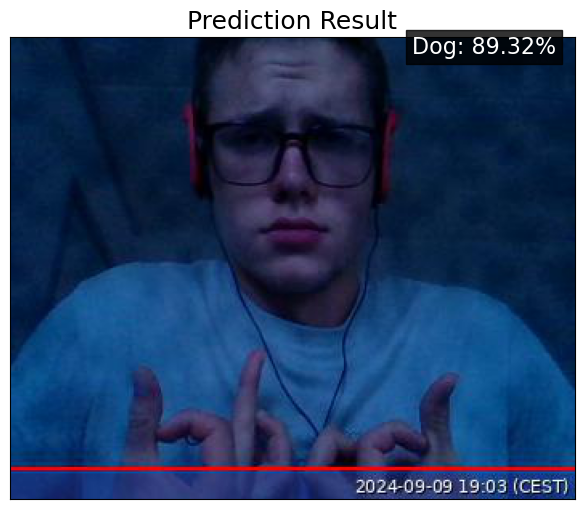

In [66]:
PredictSingleImg("/home/kikosolovic/Downloads/image22.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


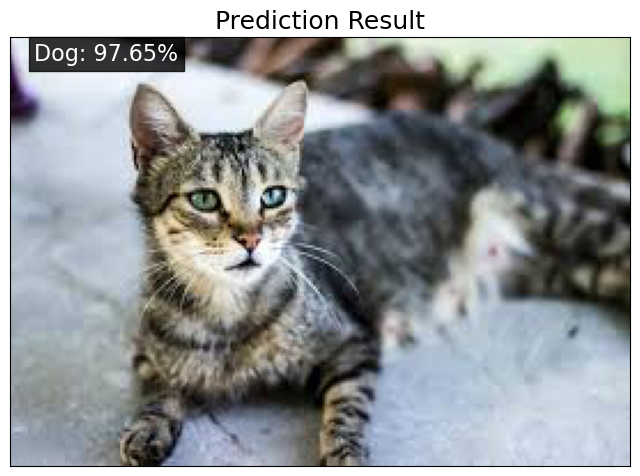

In [13]:
PredictSingleImg("/home/kikosolovic/Downloads/imag5.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


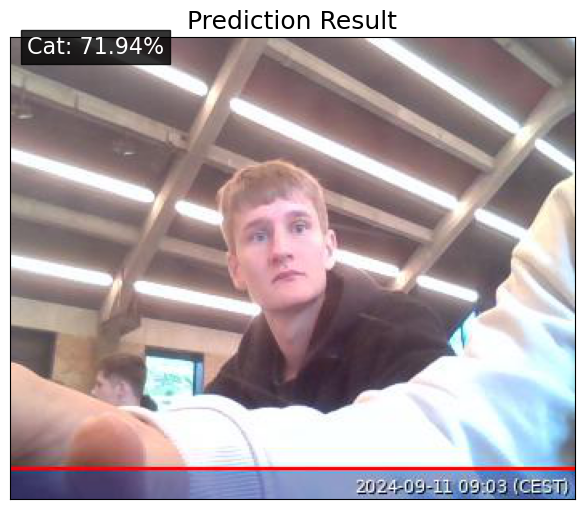

In [18]:
PredictSingleImg("/home/kikosolovic/Downloads/image6.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


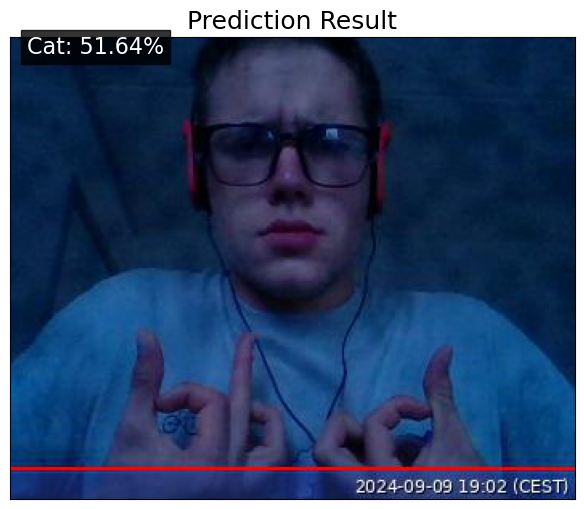

In [28]:
PredictSingleImg("/home/kikosolovic/Downloads/image.jpg")